## Probabilistic Learning on Manifolds (IDA of a 12-story RC frame)

In this example, raw data from Incremental Dynamic Analysis (IDA) of a 12-story RC frame are used as the input sample. Similar to the previous example (i.e., example1), the interested engineering demand parameters include maximum story drift ratio and peak floor acceleration. The intensity measures for quantifying the ground motion characeteristics include pseudo spectral acceleration $Sa(T_1)$, response spectral shape measture $SaRatio$, and 5-75% significant duration $D_{S5-75}$.

The IDA ground motions include 49 records with various $SaRati$ and $D_{S5-75}$, and the entire sample data include 478 points. The goal is (1) to use PLoM learn the data structure and generate more samples whose key statistics (i.e., mean and covariance) are consistent with the input samplem, and (2) to resample the PLoM-estimated EDPs given specific site hazard (i.e., a specific joint distribution of $Sa$, $SaRatio$, and $D_{S5-75}$).

### Import python modules

In [1]:
import numpy as np
import random
import time
from math import pi
import pandas as pd
from ctypes import *
%matplotlib notebook
import matplotlib.pyplot as plt
import sys

### Import PLoM modules

In [2]:
sys.path.insert(1, '../../')
from PLoM import *

### Load Incremental (IDA) Data
MSA data are loaded via a comma-separate value (csv) file. The first row contains column names for both predictors (X) and responses (y). The following rows are input sample data. Users are expected to specif the csv filename.

2021-09-20 03:25:30.240677  RUNNING-MSG --NEW LOG STARTING FROM THIS LINE-- 
2021-09-20 03:25:30.242299  RUNNING-MSG PLoM: Running directory /home/kuanshi/Documents/PLoM/IDA initialized. 
2021-09-20 03:25:30.257587  RUNNING-MSG PLoM: database server initialized. 
2021-09-20 03:25:30.258522  RUNNING-MSG PLoM: visualization folder /home/kuanshi/Documents/PLoM/IDA/FigOut initialized. 
2021-09-20 03:25:30.268546  RUNNING-MSG PLoM.load_data: loaded data size = (1059, 27). 
2021-09-20 03:25:30.297278  RUNNING-MSG PLoM.initialize_data: current X0 size = (1059, 27). 
2021-09-20 03:25:30.297724  RUNNING-MSG PLoM.initialize_data: X0 and X0_size saved to database. 


<IPython.core.display.Javascript object>


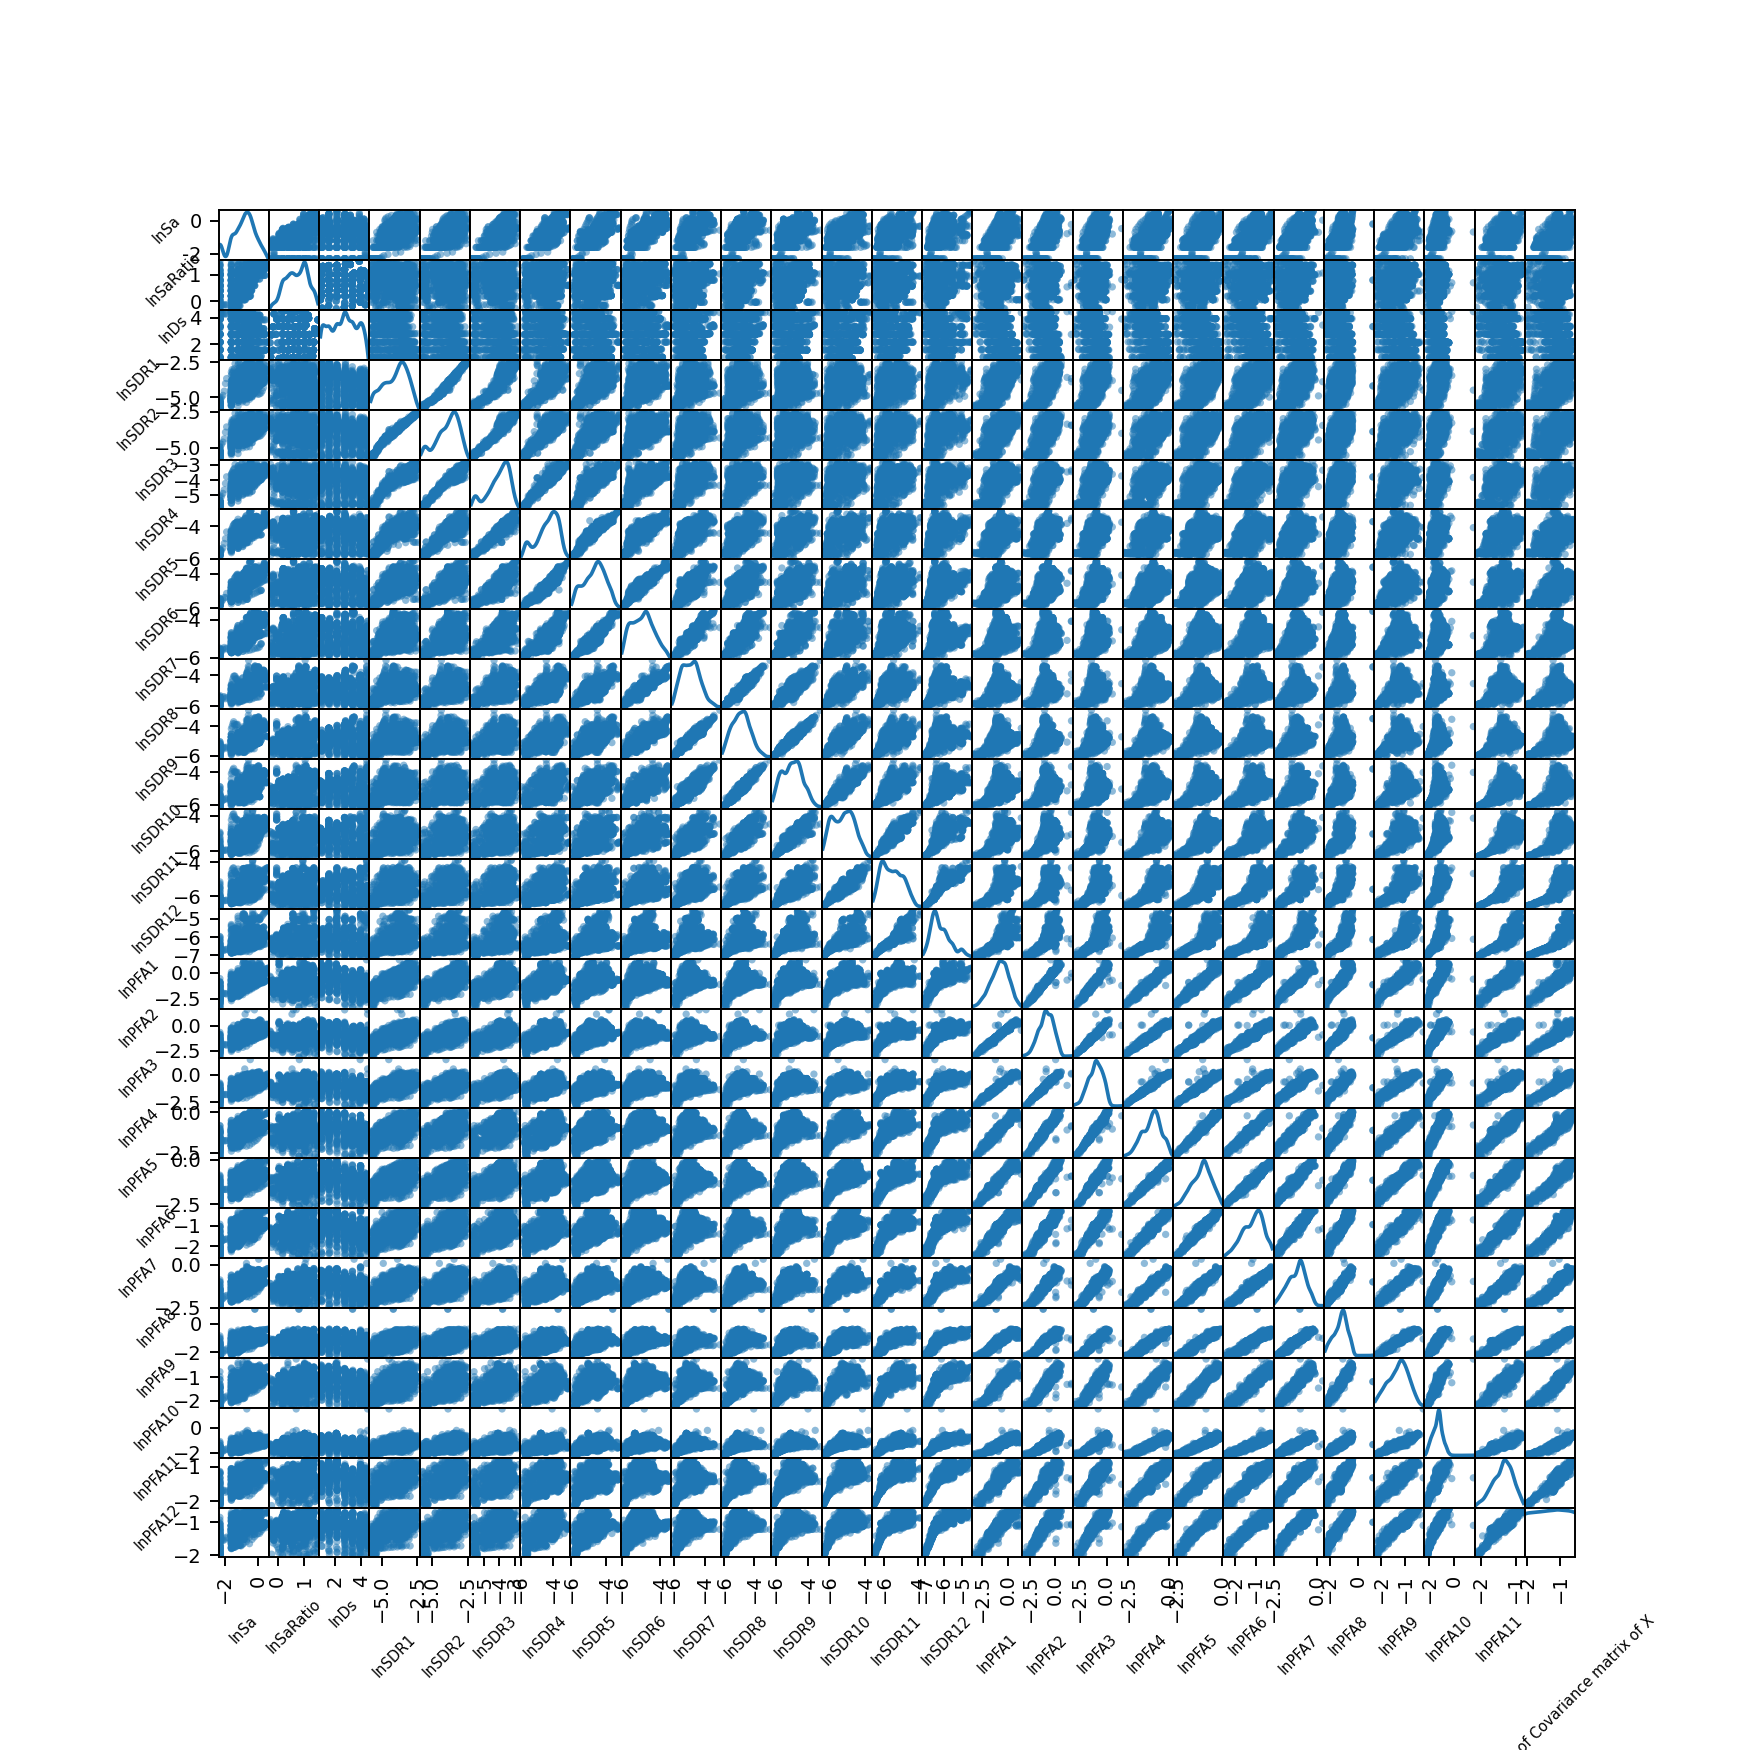

2021-09-20 03:25:52.849074  RUNNING-MSG PLoM: ScatterMatrix_X0.png saved in /home/kuanshi/Documents/PLoM/IDA/FigOut. 
2021-09-20 03:25:52.849651  WARNING-MSG PLoM.add_constraints: no user-defined constraint - please use add_constraints(constraints_file=X) to add new constraints if any. 
2021-09-20 03:25:52.849963  RUNNING-MSG PLoM: using RunAlgorithm(n_mc=n_mc,epsilon_pca=epsilon_pca,epsilon_kde) to run simulations. 


In [8]:
# Filename
filename = './data/response_frame12_ida_comb.csv'
model = PLoM(model_name='IDA', data=filename, col_header=True, plot_tag=True)

### Configuring tasks
Please specify tasks to run - the list of tasks can be run in sqeunce or invidivdual tasks can be run separately.

In [9]:
tasks = ['DataNormalization','RunPCA','RunKDE','ISDEGeneration']

### Step 0: Scaling the data

In [10]:
# Configure the task
model.ConfigTasks(['DataNormalization'])
# Launch the run
model.RunAlgorithm()

2021-09-20 03:26:07.842829  RUNNING-MSG PLoM.config_tasks: the following tasks is configured to run: DataNormalization. 
2021-09-20 03:26:07.845565  RUNNING-MSG PLoM.RunAlgorithm: data normalization completed. 
2021-09-20 03:26:07.898332  RUNNING-MSG PLoM.RunAlgorithm: X_range, X_min, X_scaled and X_scaled_mean saved. 
2021-09-20 03:26:07.948335  RUNNING-MSG PLoM.RunAlgorithm: simulation completed with task(s) DataNormalization done. 


### Step 1: Principal Component Analysis (PCA)

2021-09-20 03:26:49.191465  RUNNING-MSG PLoM.config_tasks: the following tasks is configured to run: RunPCA. 
2021-09-20 03:26:49.212621  RUNNING-MSG PLoM.RunPCA: considered number of PCA components = 27 


<IPython.core.display.Javascript object>


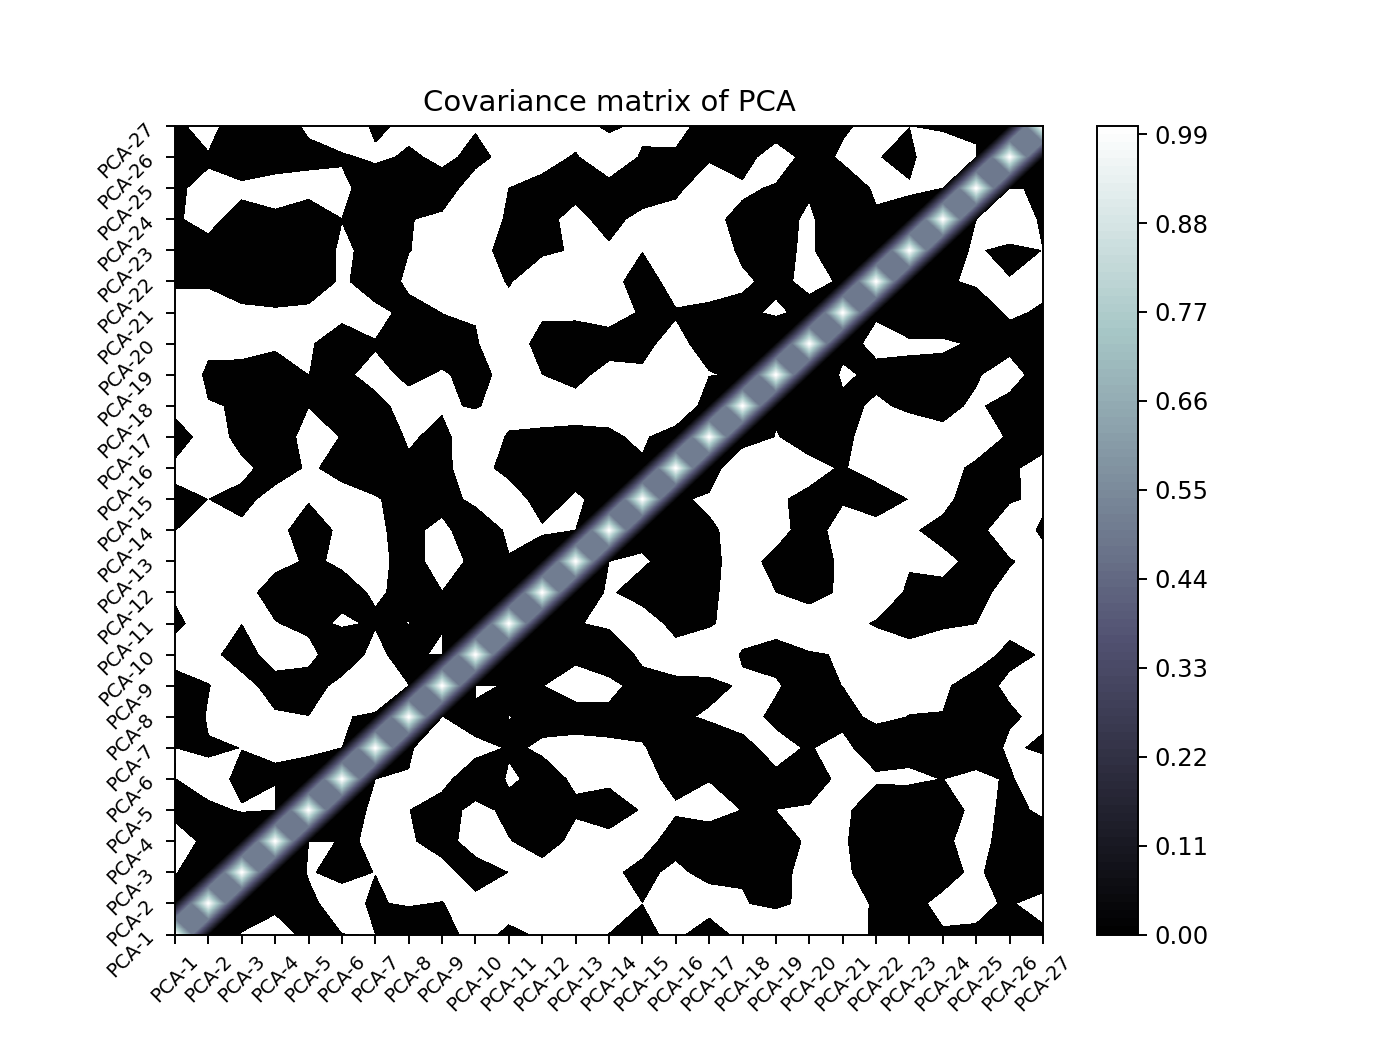

2021-09-20 03:26:49.990580  RUNNING-MSG PLoM: PCA_CovarianceMatrix.png saved in /home/kuanshi/Documents/PLoM/IDA/FigOut. 
2021-09-20 03:26:49.991145  RUNNING-MSG PLoM.RunAlgorithm: PCA completed. 
2021-09-20 03:26:50.035040  RUNNING-MSG PLoM.RunAlgorithm: X_PCA, EigenValue_PCA and EigenVector_PCA saved. 
2021-09-20 03:26:50.086956  RUNNING-MSG PLoM.RunAlgorithm: simulation completed with task(s) RunPCA done. 


In [13]:
# Tolerance for truncating principal components
tol_pca = 1e-6
# Configure the task
model.ConfigTasks(['RunPCA'])
# Launch the run
model.RunAlgorithm(epsilon_pca=tol_pca)

### Step 2: Kernel Density Estimation (KDE)

2021-09-20 03:27:03.898326  RUNNING-MSG PLoM.config_tasks: the following tasks is configured to run: RunKDE. 
2021-09-20 03:27:09.647820  RUNNING-MSG PLoM.RunAlgorithm: kernel density estimation completed. 
2021-09-20 03:27:09.722342  RUNNING-MSG PLoM.RunAlgorithm: KDE, X_KDE and EigenValues_KDE saved. 


<IPython.core.display.Javascript object>


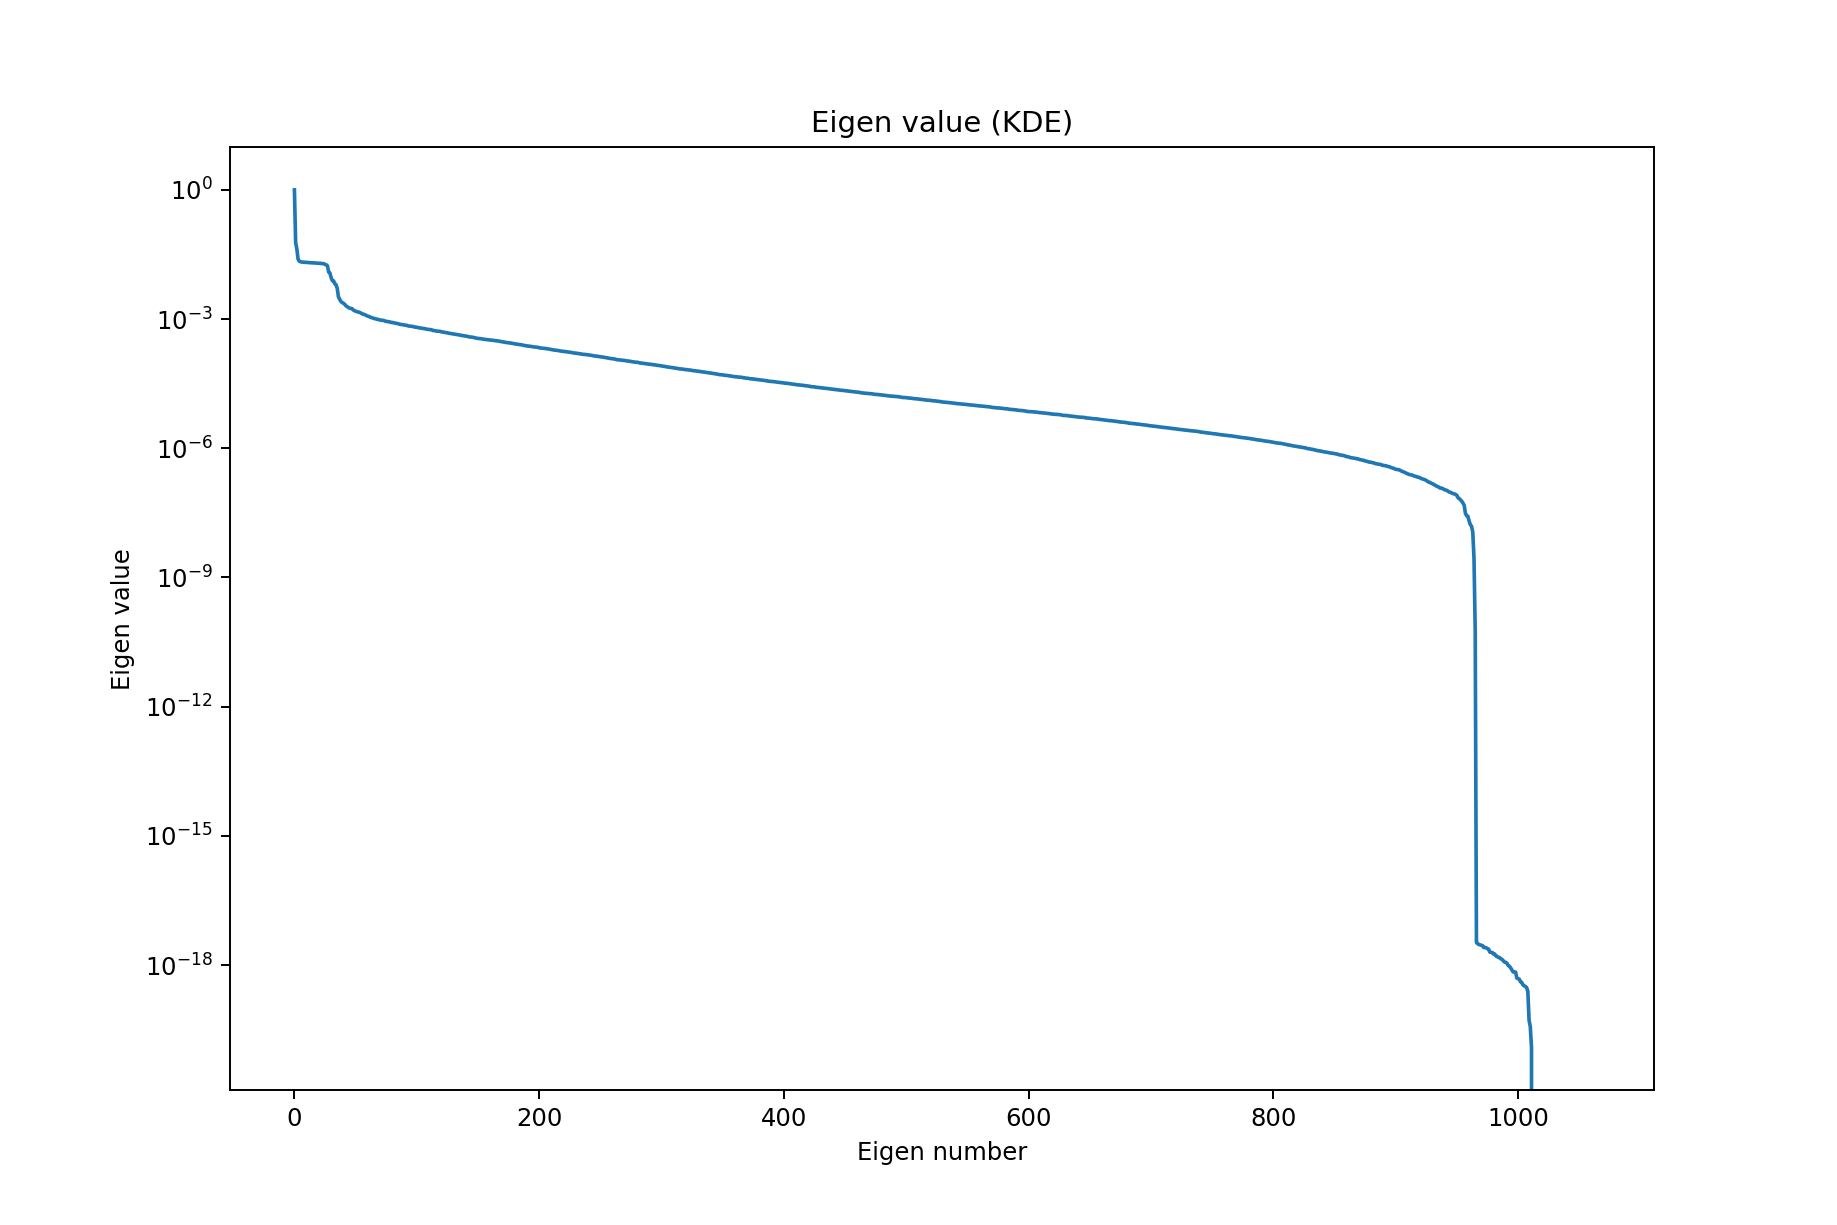

2021-09-20 03:27:10.328103  RUNNING-MSG PLoM: KDE_EigenValue.png saved in /home/kuanshi/Documents/PLoM/IDA/FigOut. 
2021-09-20 03:27:10.328702  RUNNING-MSG PLoM.RunAlgorithm: diffusion maps completed. 
2021-09-20 03:27:10.373036  RUNNING-MSG PLoM.RunAlgorithm: KDE_g, KDE_m, KDE_a and KDE_Z saved. 
2021-09-20 03:27:10.574803  RUNNING-MSG PLoM.RunAlgorithm: simulation completed with task(s) RunKDE done. 


In [14]:
# Smoothing parameter in the KDE
sp = 25
# Configure the task
model.ConfigTasks(['RunKDE'])
# Launch the run
model.RunAlgorithm(epsilon_kde=sp)

### Step 3: Create the generator

In [16]:
# Extra parameters for ISDE generation
new_sample_num_ratio = 20
tol_PCA2 = 1e-5
# Configure the task
model.ConfigTasks(['ISDEGeneration'])
# Launch the run
model.RunAlgorithm(n_mc = new_sample_num_ratio, tol_PCA2 = tol_PCA2)

2021-09-20 03:28:20.209374  RUNNING-MSG PLoM.config_tasks: the following tasks is configured to run: ISDEGeneration. 
delta t:  0.18844382365263854
2021-09-20 03:29:14.836125  RUNNING-MSG PLoM.ISDEGeneration: new generations are simulated. 
2021-09-20 03:29:14.858978  RUNNING-MSG PLoM.RunAlgorithm: Realizations generated. 
2021-09-20 03:29:14.878827  RUNNING-MSG PLoM.RunAlgorithm: X_new saved. 
2021-09-20 03:29:14.947463  RUNNING-MSG PLoM.RunAlgorithm: simulation completed with task(s) ISDEGeneration done. 


### Step 4: Exporting data

In [17]:
# Available data list
model.export_results()

2021-09-20 03:29:14.990118  RUNNING-MSG PLoM.export_results: available data /DS_EigenValue_PCA,/DS_EigenValues_KDE,/DS_EigenVector_PCA,/DS_Errors,/DS_KDE_Z,/DS_KDE_a,/DS_KDE_g,/DS_KDE_m,/DS_N,/DS_NumComp_PCA,/DS_X0,/DS_X_KDE,/DS_X_PCA,/DS_X_min,/DS_X_new,/DS_X_range,/DS_X_scaled,/DS_X_scaled_mean,/DS_c_v,/DS_hat_s_v,/DS_n,/DS_s_v,/EigenValue_PCA,/EigenValues_KDE,/EigenVector_PCA,/Errors,/KDE_Z,/KDE_a,/KDE_g,/KDE_m,/N,/NumComp_PCA,/X0,/X_KDE,/X_PCA,/X_min,/X_new,/X_range,/X_scaled,/X_scaled_mean,/basic,/c_v,/constraints_file,/hat_s_v,/n,/s_v. 


In [18]:
# Pick up the original and new realizations, X0 and X_new
model.export_results(data_list=['/X0','/X_new'], file_format_list=['csv','csv'])

2021-09-20 03:29:18.294310  RUNNING-MSG PLoM.export_results: /X0 is exported in /home/kuanshi/Documents/PLoM/IDA/DataOut/X0.csv. 
2021-09-20 03:29:18.797579  RUNNING-MSG PLoM.export_results: /X_new is exported in /home/kuanshi/Documents/PLoM/IDA/DataOut/X_new.csv. 


### Post-processing
We would like to check the basic statistics of the input sample (i.e., IDA) and the generated new realizations by PLoM. The key metrics include the median, standard deviation, and correlation coefficient matrix of different structural responses.

In [22]:
# Load results
df_ida = pd.read_csv('/home/kuanshi/Documents/PLoM/IDA/DataOut/X0.csv')
df_plom = pd.read_csv('/home/kuanshi/Documents/PLoM/IDA/DataOut/X_new.csv')
print(df_ida.head)
print(df_plom.head)

<bound method NDFrame.head of       Unnamed: 0      lnSa  lnSaRatio      lnDs    lnSDR1    lnSDR2    lnSDR3  \
0              0 -2.302585  -0.262842  1.050822 -5.095845 -4.934669 -5.312743   
1              1 -1.609438  -0.262842  1.050822 -3.420081 -3.392494 -3.618831   
2              2 -1.560648  -0.262842  1.050822 -3.309468 -3.274222 -3.495328   
3              3 -1.514128  -0.262842  1.050822 -3.203047 -3.168589 -3.389196   
4              4 -1.469676  -0.262842  1.050822 -3.098456 -3.069364 -3.297640   
...          ...       ...        ...       ...       ...       ...       ...   
1054        1054  0.000000   1.134935  4.195998 -3.405892 -3.302391 -3.432685   
1055        1055  0.095310   1.134935  4.195998 -3.197254 -3.091884 -3.237837   
1056        1056  0.104360   1.134935  4.195998 -3.078542 -3.008260 -3.211039   
1057        1057  0.113329   1.134935  4.195998 -3.030616 -2.972604 -3.192538   
1058        1058  0.122218   1.134935  4.195998 -2.918612 -2.876681 -3.117340  

<IPython.core.display.Javascript object>


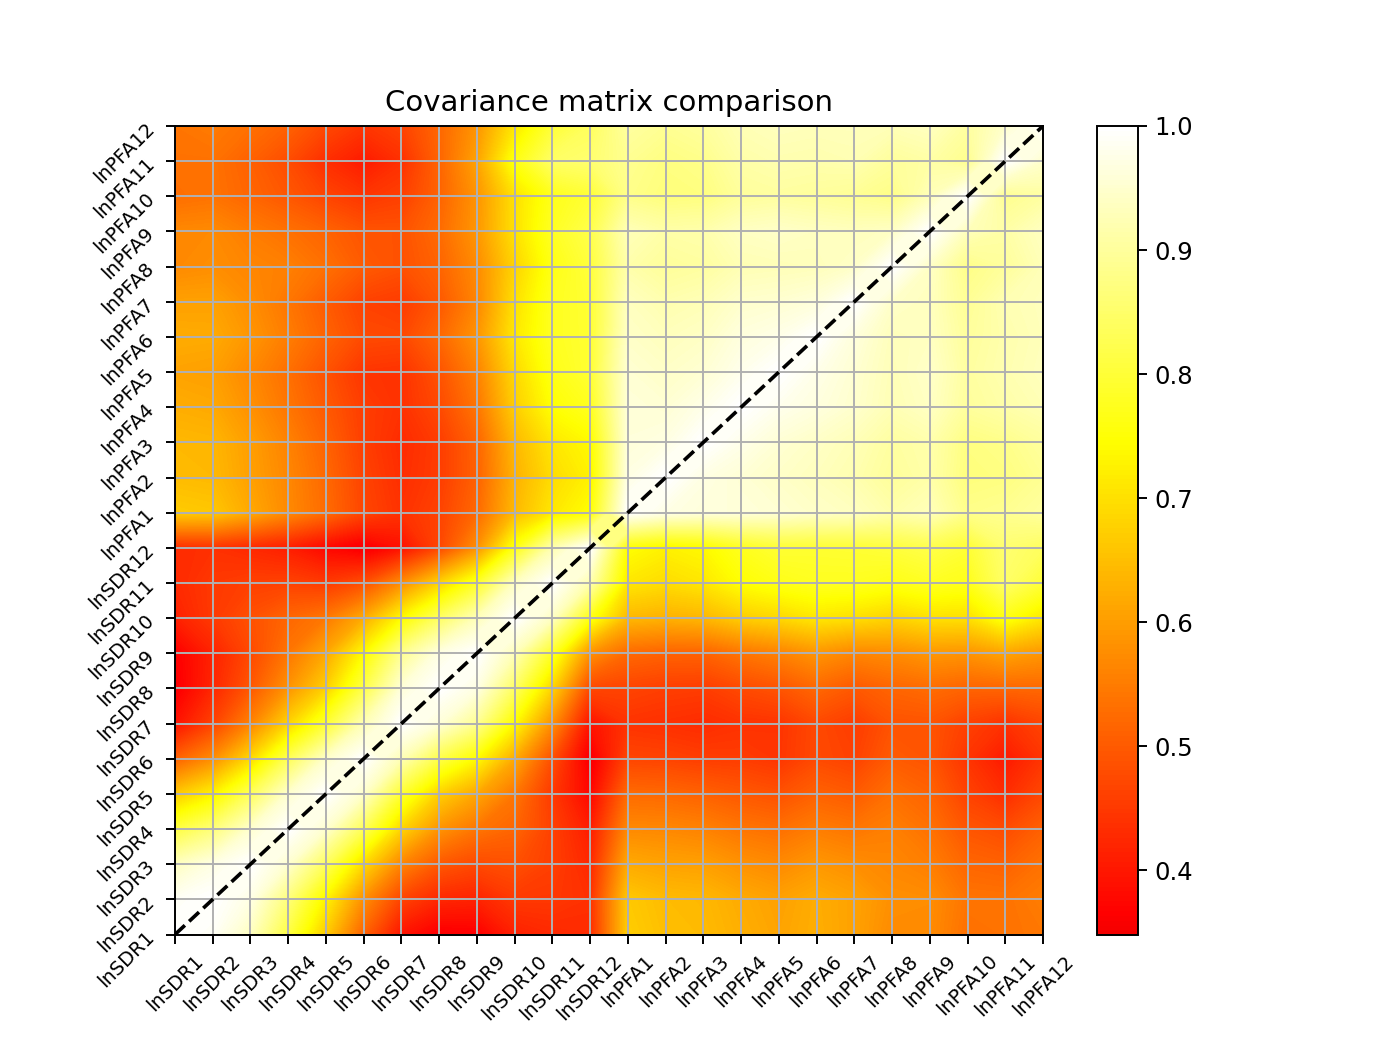

<IPython.core.display.Javascript object>


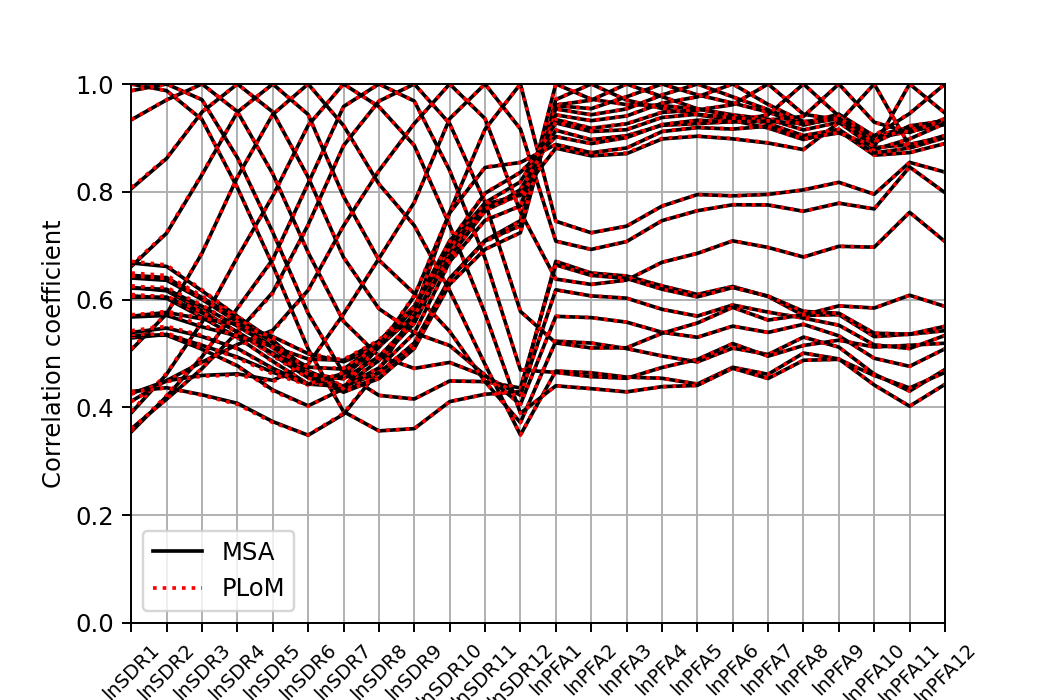

In [23]:
x0 = df_ida.iloc[:,1:].T
x_c = df_plom.iloc[:,1:].T
x_name = x0.index.tolist()
x0 = np.array(x0)
x_c = np.array(x_c)
n = 27
# Correlation coefficient matrix
c_ida = np.corrcoef(x0)
c_plom = np.corrcoef(x_c)
c_combine = c_ida
tmp = np.triu(c_plom).flatten()
tmp = tmp[tmp != 0]
c_combine[np.triu_indices(27)] = tmp

# Plot covariance matrix
fig, ax = plt.subplots(figsize=(8,6))
ctp = ax.contourf(c_combine[3:,3:], cmap=plt.cm.hot, levels=1000)
ctp.set_clim(0,1)
ax.plot([0, 23], [0, 23], 'k--')
ax.set_xticks(list(range(n-3)))
ax.set_yticks(list(range(n-3)))
ax.set_xticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_yticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_title('Covariance matrix comparison')
ax.grid()
cbar = fig.colorbar(ctp,ticks=[x/10 for x in range(11)])
plt.show()

# Plot the cross-section of correlation matrix
fig, ax = plt.subplots(figsize=(6,4))
ax.plot([0],[0],'k-',label='MSA')
ax.plot([0],[0],'r:',label='PLoM')
for i in range(n-3):
    ax.plot(np.array(range(n-3)),c_ida[i+3][3:],'k-')
    ax.plot(np.array(range(n-3)),c_plom[i+3][3:],'r:')
ax.set_xticks(list(range(n-3)))
ax.set_xticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_ylabel('Correlation coefficient')
ax.set_ylim([0,1])
ax.set_xlim([0,n-4])
ax.legend()
ax.grid()
plt.show()

### Hazard Adjustment
This section can be used to process the PLoM predictions from raw IDA training. Site specific hazard information is needed as an input. An example site hazard csv file is provided, the first column is the Sa intensity, the second column is the median SaRatio, the third column is the median duration, and the last four columns are covariance matrix entries.

In [24]:
# Load site hazard information
shz = pd.read_csv('./data/site_hazard.csv')
sa_levels = shz['Sa']
print(shz)
print(np.array(shz.iloc[0]['cov11':]).reshape((2,2)))

       Sa  mSaRatio       mDs     cov11     cov12     cov21   cov22
0  0.1690  0.494493  2.187499  0.073322 -0.011835 -0.011835  0.2306
1  0.2594  0.533634  2.150060  0.073322 -0.011835 -0.011835  0.2306
2  0.3696  0.586958  2.116164  0.073322 -0.011835 -0.011835  0.2306
3  0.5492  0.696371  2.124474  0.073322 -0.011835 -0.011835  0.2306
4  0.7131  0.815519  2.134961  0.073322 -0.011835 -0.011835  0.2306
5  0.9000  0.917086  2.228618  0.073322 -0.011835 -0.011835  0.2306
[[ 0.07332215 -0.01183476]
 [-0.01183476  0.2306    ]]


In [25]:
# Draw samples from the site distribution
num_rlz = 1000 # sample size
np.random.seed(1) # random seed for replicating results
rlz_imv = []
for i in range(len(shz.index)):
    rlz_imv.append(np.random.multivariate_normal(mean=[shz['mSaRatio'][i],shz['mDs'][i]],cov=np.array(shz.iloc[i]['cov11':]).reshape((2,2)),size=num_rlz))

<IPython.core.display.Javascript object>


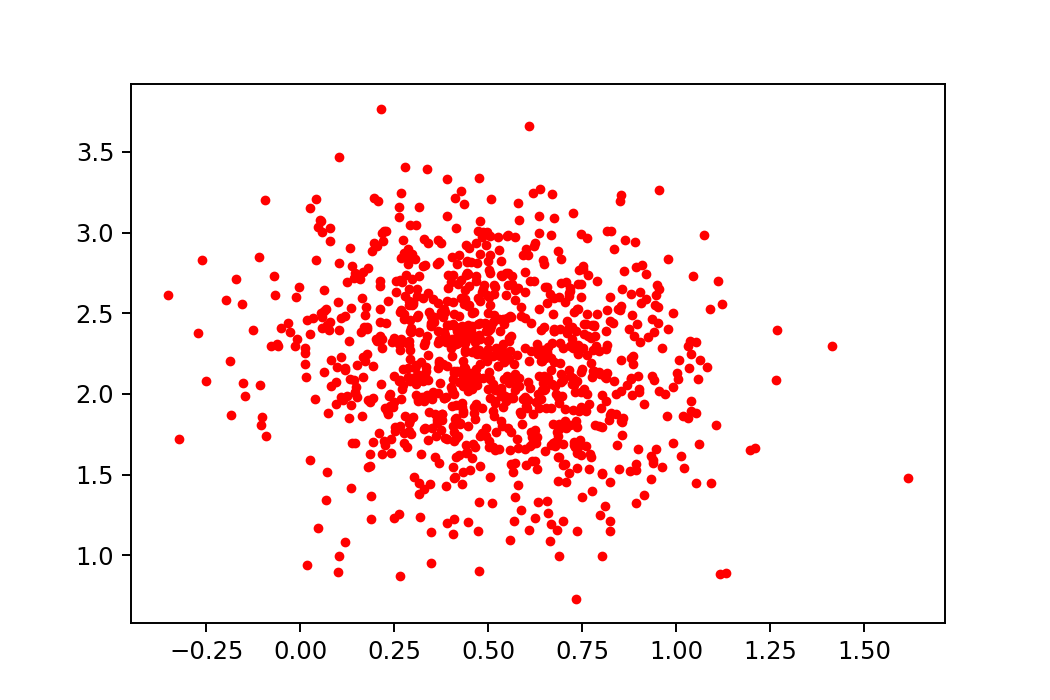

In [26]:
# Search nearest PLoM data points for each sample in rlz_imv
lnsa_plom = x_c[0]
lnsaratio_plom = x_c[1]
lnds_plom = x_c[2]

# Create the nearest interporator and interpolate data
from scipy.interpolate import NearestNDInterpolator
res_edp = []
for i in range(n-3):
    # Loop all EDPs
    interp_nn = NearestNDInterpolator(list(zip(lnsa_plom,lnsaratio_plom,lnds_plom)),x_c[3+i])
    pred_nn = []
    for j in range(len(shz.index)):
        # Loop all intensity levels
        pred_nn.append(interp_nn(np.ones(rlz_imv[j][:,0].shape)*np.log(shz['Sa'][j]),
                                 rlz_imv[j][:,0],rlz_imv[j][:,1]))
    res_edp.append(pred_nn)
        
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(rlz_imv[0][:,0],rlz_imv[0][:,1],'r.',label='Resample')
plt.show()

In [27]:
ref_msa = pd.read_csv('./data/response_rcf12_msa_la_nc.csv')

In [28]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2,weights='distance',algorithm='auto',p=2)
res = []
for i in range(n-3):
    # Loop all EDPs
    neigh.fit(np.transpose(x_c[0:3]),x_c[i+3])
    pred = []
    for j in range(len(shz.index)):
        # Loop all intensity levels
        pred.append(neigh.predict(np.array((np.ones(rlz_imv[j][:,0].shape)*np.log(shz['Sa'][j]),rlz_imv[j][:,0],rlz_imv[j][:,1])).T))
    res.append(pred)

<IPython.core.display.Javascript object>


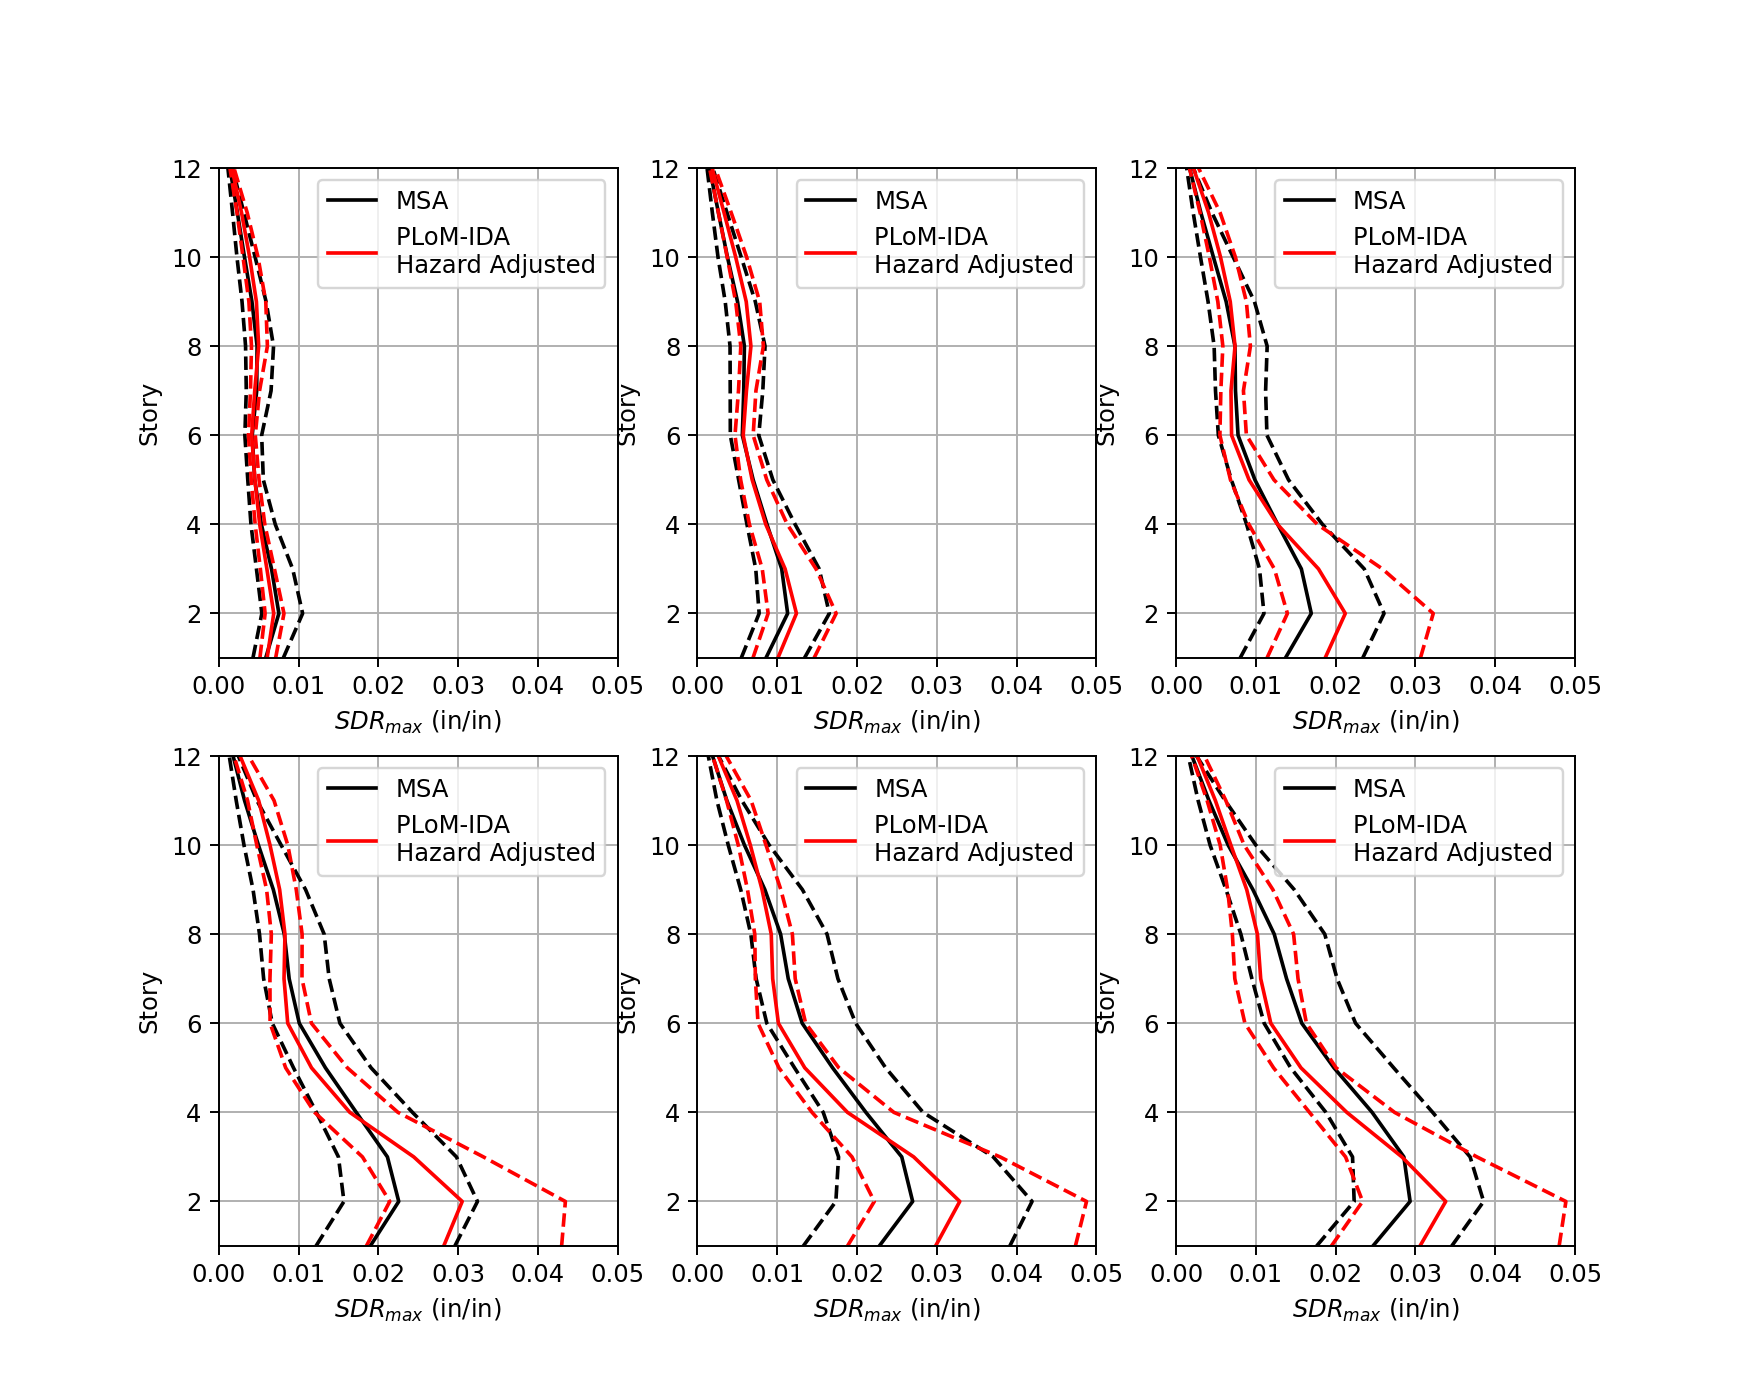

In [30]:
num_story = 12
num_sa = 6
sdr_cur_med_msa = np.zeros((num_story,num_sa))
sdr_cur_std_msa = np.zeros((num_story,num_sa))
sdr_cur_med_plom = np.zeros((num_story,num_sa))
sdr_cur_std_plom = np.zeros((num_story,num_sa))
for i in range(12):
    for j in range(6):
        sdr_cur_msa = ref_msa.loc[ref_msa['Sa']==shz['Sa'][j]][x_name[i+3][2:]]
        sdr_cur_med_msa[i,j] = np.exp(np.mean(np.log(sdr_cur_msa)))
        sdr_cur_std_msa[i,j] = np.std(np.log(sdr_cur_msa))
        sdr_cur_plom = np.exp(res[i][j])
        sdr_cur_med_plom[i,j] = np.exp(np.mean(res[i][j]))
        sdr_cur_std_plom[i,j] = np.std(res[i][j])
        
plt.figure(figsize=(10,8))
story_list = list(range(1,num_story+1))
for i in range(6):
    plt.subplot(2,3,i+1)
    ax = plt.gca()
    ax.plot([0],[0],'k-',label='MSA')
    ax.plot([0],[0],'r-',label='PLoM-IDA \nHazard Adjusted')
    ax.plot(sdr_cur_med_msa[:,i],story_list,'k-')
    ax.plot(sdr_cur_med_msa[:,i]*np.exp(sdr_cur_std_msa[:,i]),story_list,'k--')
    ax.plot(sdr_cur_med_msa[:,i]/np.exp(sdr_cur_std_msa[:,i]),story_list,'k--')
    ax.plot(sdr_cur_med_plom[:,i],story_list,'r-')
    ax.plot(sdr_cur_med_plom[:,i]*np.exp(sdr_cur_std_plom[:,i]),story_list,'r--')
    ax.plot(sdr_cur_med_plom[:,i]/np.exp(sdr_cur_std_plom[:,i]),story_list,'r--')
    ax.set_xlim(0.0,0.05)
    ax.set_ylim(1,12)
    ax.grid()
    ax.legend()
    ax.set_xlabel('$SDR_{max}$ (in/in)')
    ax.set_ylabel('Story')

<IPython.core.display.Javascript object>


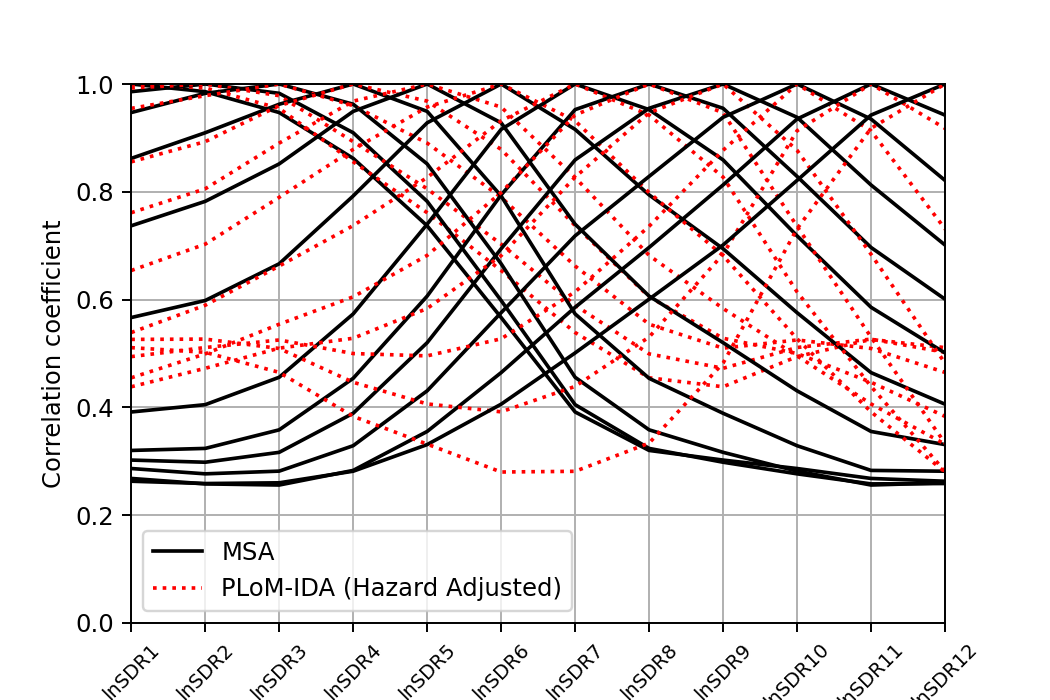

In [31]:
x0_ref = []
for i in range(n):
    x0_ref.append([np.log(x) for x in ref_msa.iloc[:, i].values.tolist()])

c_msa = np.corrcoef(x0_ref)
res_conct = []
for i in range(n-3):
    tmp = []
    for j in range(len(shz.index)):
        tmp = tmp+res[i][j].tolist()
    res_conct.append(tmp)
c_plom = np.corrcoef(res_conct)
# Plot correlation of resampled data
fig, ax = plt.subplots(figsize=(6,4))
ax.plot([0],[0],'k-',label='MSA')
ax.plot([0],[0],'r:',label='PLoM-IDA (Hazard Adjusted)')
for i in range(n-15):
    ax.plot(np.array(range(n-3)),c_msa[i+3][3:],'k-')
    ax.plot(np.array(range(n-3)),c_plom[i],'r:')
ax.set_xticks(list(range(n-3)))
ax.set_xticklabels(x_name[3:], fontsize=8, rotation=45)
ax.set_ylabel('Correlation coefficient')
ax.set_ylim([0,1])
ax.set_xlim([0,n-16])
ax.legend()
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


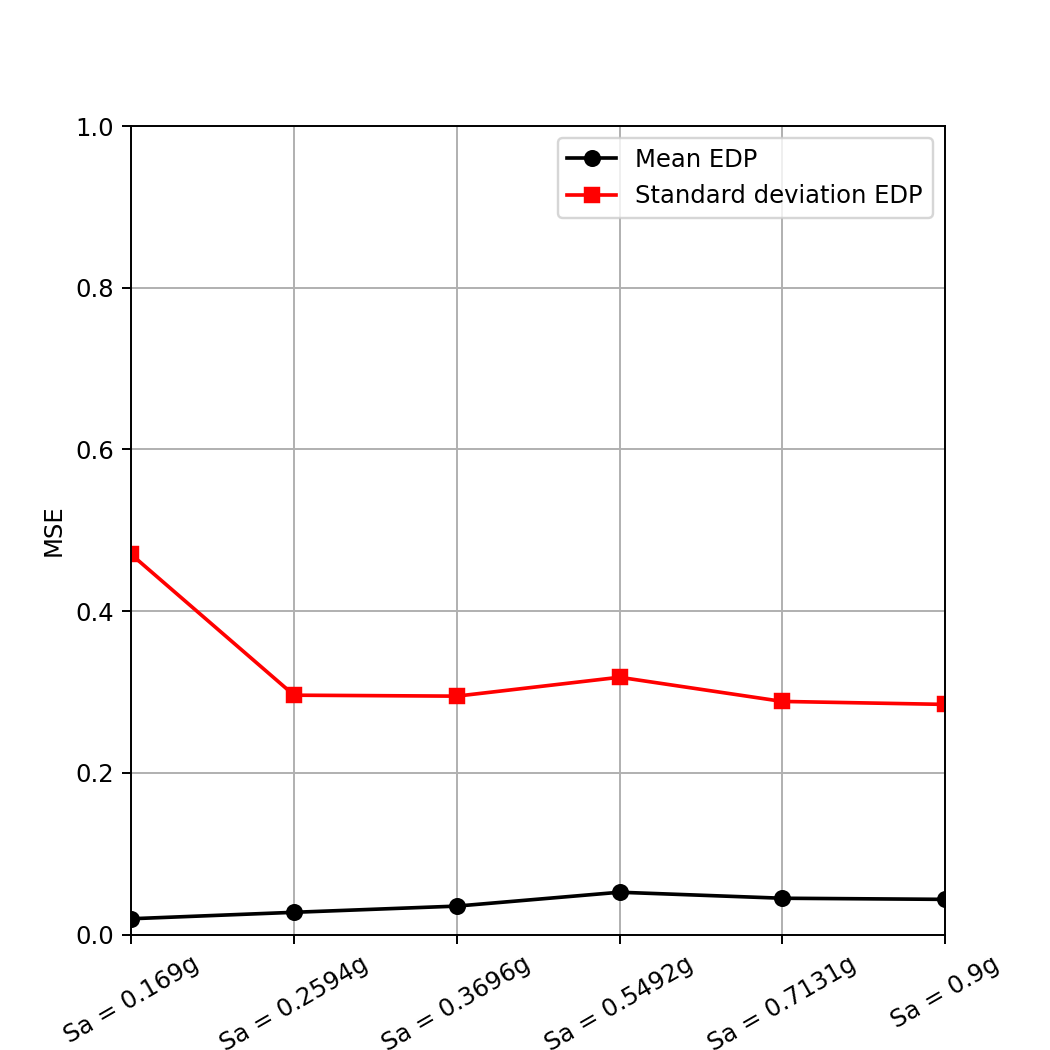

In [32]:
# Estimation errors
err_med = np.linalg.norm(np.log(sdr_cur_med_plom) - np.log(sdr_cur_med_msa),axis=0)/np.linalg.norm(np.log(sdr_cur_med_msa),axis=0)
err_std = np.linalg.norm(sdr_cur_std_plom - sdr_cur_std_msa,axis=0)/np.linalg.norm(sdr_cur_std_msa,axis=0)
# Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(list(range(6)),err_med,'ko-',label='Mean EDP')
ax.plot(list(range(6)),err_std,'rs-',label='Standard deviation EDP')
ax.set_xticks(list(range(6)))
ax.set_xticklabels(['Sa = '+str(x)+'g' for x in sa_levels],rotation=30)
ax.set_xlim([0,5])
ax.set_ylim([0,1])
ax.set_ylabel('MSE')
ax.grid()
ax.legend()
plt.show()